<a href="https://colab.research.google.com/github/AtlastDeepLearning/Intestinal-Parasite-Classification-LW-CNN/blob/main/efficientNet_B0_LW_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

# Grayscaled Feature Extraction in Efficientnet

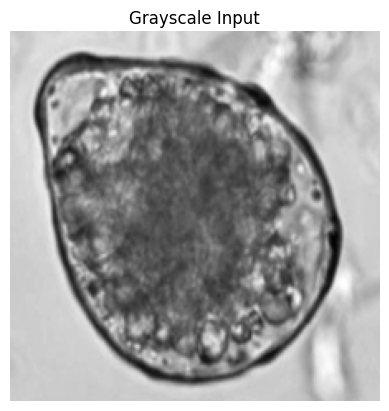

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img_path, target_size=(224, 224)):
    # Read image in grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Error: Could not load image from {img_path}")

    # Resize to model input size
    img = cv2.resize(img, target_size)

    # Expand to 3 channels for pretrained CNNs
    img = np.stack([img] * 3, axis=-1)

    # Normalize
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Example usage
img_path = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/train/ascaris_lumbricoides/(1) 21090.png"  # 👈 Make sure this file exists
gray_img = preprocess_image(img_path)

plt.imshow(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), cmap="gray")
plt.title("Grayscale Input")
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


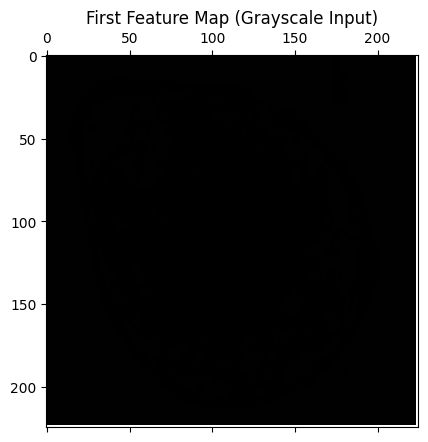

In [ ]:
# Extract activations from grayscale image
activations = activation_model.predict(gray_img)

# Visualize the first feature map from the first layer
plt.matshow(activations[0][0, :, :, 0], cmap='gray')
plt.title("First Feature Map (Grayscale Input)")
plt.show()

# Modified Grayscaled Feature Extraction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


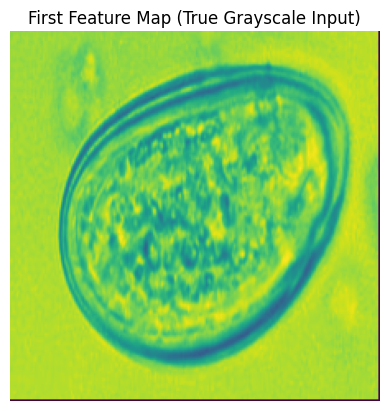

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Input
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 🔹 Load EfficientNetB0 but exclude top
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224,224,1))

# Example: Load and preprocess grayscale image
def preprocess_gray(img_path, target_size=(224,224)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found or path incorrect")
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=-1)  # add channel dim
    img = np.expand_dims(img, axis=0)   # batch dim
    return img

# Get activations from first few conv layers
layer_names = [layer.name for layer in base_model.layers if "conv" in layer.name][:5]
activation_model = Model(inputs=base_model.input,
                         outputs=[base_model.get_layer(name).output for name in layer_names])

# Test with sample image
img_path = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/train/enterobius_vermicularis/(1).png"
gray_img = preprocess_gray(img_path)

activations = activation_model.predict(gray_img)

# Visualize the first feature map
first_activation = activations[0][0, :, :, 0]  # first conv, first channel
plt.imshow(first_activation, cmap="viridis")
plt.title("First Feature Map (True Grayscale Input)")
plt.axis("off")
plt.show()

# Training Code for Efficientnet b0

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [7]:
IMG_SIZE = (224, 224)  # EfficientNetB0 default
BATCH_SIZE = 16
EPOCHS = 30
DATASET_DIR_TRAIN = "/content/drive/MyDrive/Thesis/parasite/train"
DATASET_DIR_VAL = "/content/drive/MyDrive/Thesis/parasite/val"

In [8]:
def grayscale_to_rgb(img):
    # img is (H, W, 1), expand to (H, W, 3)
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    # Ensure values in [0,1]
    img = tf.image.convert_image_dtype(img, tf.float32)
    # Expand grayscale to 3-channel
    img = grayscale_to_rgb(img)
    return img

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator() # No augmentation for validation

train_gen = train_datagen.flow_from_directory(
    f"{DATASET_DIR_TRAIN}",
    target_size=IMG_SIZE,
    color_mode="grayscale",   # load as grayscale first
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    f"{DATASET_DIR_VAL}",
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

# Apply custom preprocessing to convert grayscale to RGB
def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

train_gen_processed = preprocess_generator(train_gen)
val_gen_processed = preprocess_generator(val_gen)

Found 810 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [10]:
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))  # force RGB input
)

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.4)(x)
outputs = Dense(train_gen.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Freeze base for transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [11]:
checkpoint = ModelCheckpoint("efficientnet_parasite.h5", save_best_only=True, monitor="val_accuracy", mode="max")
earlystop = EarlyStopping(patience=5, restore_best_weights=True)

# -----------------------------
# Train
# -----------------------------
history = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=EPOCHS,
    callbacks=[checkpoint, earlystop],
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6148 - loss: 0.8403

50/50 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.6173 - loss: 0.8362 - val_accuracy: 0.7750 - val_loss: 0.4447
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8861 - loss: 0.3333

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 176ms/step - accuracy: 0.8863 - loss: 0.3328 - val_accuracy: 0.9000 - val_loss: 0.2767
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9032 - loss: 0.2663

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9036 - loss: 0.2657 - val_accuracy: 0.9500 - val_loss: 0.2392
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.9476 - loss: 0.1990 - val_accuracy: 0.9459 - val_loss: 0.1595
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 321ms/step - accuracy: 0.9552 - loss: 0.1699 - val_accuracy: 0.9189 - val_loss: 0.1978
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9526 - loss: 0.1604

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9526 - loss: 0.1602 - val_accuracy: 0.9730 - val_loss: 0.1524
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 199ms/step - accuracy: 0.9755 - loss: 0.1292 - val_accuracy: 0.9625 - val_loss: 0.1431
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9692 - loss: 0.1221

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9690 - loss: 0.1222 - val_accuracy: 0.9875 - val_loss: 0.1075
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.9776 - loss: 0.1111 - val_accuracy: 0.9750 - val_loss: 0.1088
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.9694 - loss: 0.0925

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9695 - loss: 0.0924 - val_accuracy: 1.0000 - val_loss: 0.0654
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.9806 - loss: 0.0911 - val_accuracy: 0.9865 - val_loss: 0.0954
Epoch 12/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.9872 - loss: 0.0672 - val_accuracy: 0.9865 - val_loss: 0.0818
Epoch 13/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.9898 - loss: 0.0833 - val_accuracy: 0.9875 - val_loss: 0.0876
Epoch 14/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9824 - loss: 0.0743 - val_accuracy: 1.0000 - val_loss: 0.0641
Epoch 15/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 203ms/step - accuracy: 0.9778 - loss: 0.0645 - val_accuracy: 0.9875 - val_loss: 0.0618
Epoch 16/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9765 - loss: 0.0693 - val_accuracy: 1.0000 - val_loss: 0.0384
Epoch 17/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.9920 - loss: 0.0590 - val_accuracy: 0.9

In [12]:
for layer in base_model.layers[-30:]:  # unfreeze last 30 layers
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=10,
    callbacks=[checkpoint, earlystop],
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 689ms/step - accuracy: 0.9191 - loss: 0.2321 - val_accuracy: 0.9730 - val_loss: 0.0560
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 244ms/step - accuracy: 0.9467 - loss: 0.1742 - val_accuracy: 1.0000 - val_loss: 0.0306
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.9478 - loss: 0.1865 - val_accuracy: 1.0000 - val_loss: 0.0223
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.9626 - loss: 0.1362 - val_accuracy: 1.0000 - val_loss: 0.0205
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9666 - loss: 0.1306 - val_accuracy: 0.9865 - val_loss: 0.0516
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.9585 - loss: 0.1298 - val_accuracy: 0.9865 - val_loss: 0.0543
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9675 - loss: 0.1403 - val_accuracy: 0.9865 - val_loss: 0.0475
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.9698 - loss: 0.1157 - val_accura

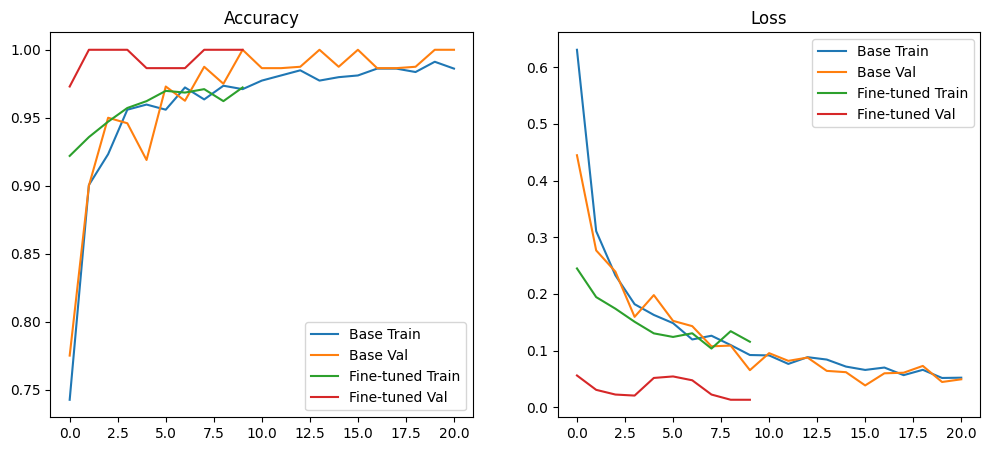

In [13]:
def plot_history(histories, title="Training History"):
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    for name, history in histories:
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val')
    plt.title("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    for name, history in histories:
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], label=f'{name} Val')
    plt.title("Loss")
    plt.legend()

    plt.show()

plot_history([("Base", history), ("Fine-tuned", history_fine)])

In [14]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
val_gen.reset()
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step


In [16]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels, digits=4))


Classification Report:
                         precision    recall  f1-score   support

    ascaris_lumbriocode     1.0000    1.0000    1.0000        30
enterobius_vermicularis     1.0000    0.9667    0.9831        30
    trichuris_trichuria     0.9677    1.0000    0.9836        30

               accuracy                         0.9889        90
              macro avg     0.9892    0.9889    0.9889        90
           weighted avg     0.9892    0.9889    0.9889        90



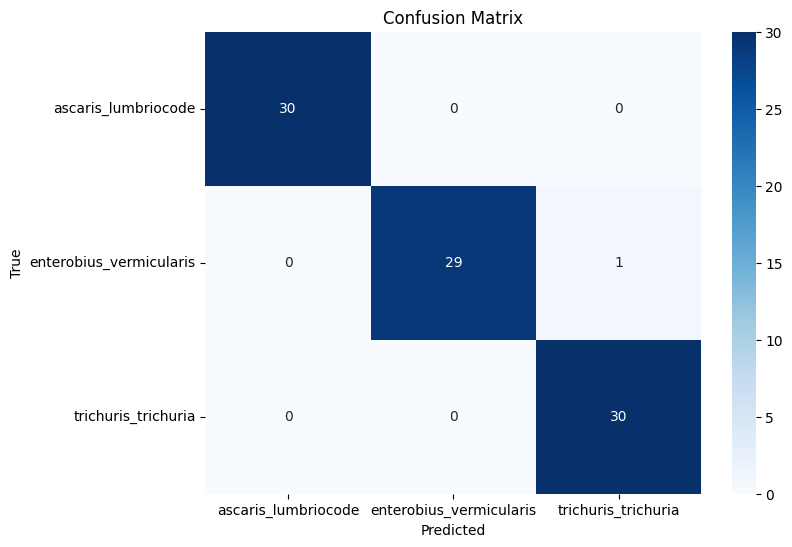

In [17]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [18]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Macro (treats all classes equally)
f1_macro = f1_score(y_true, y_pred, average="macro")
precision_macro = precision_score(y_true, y_pred, average="macro")
recall_macro = recall_score(y_true, y_pred, average="macro")

# Weighted (accounts for imbalance)
f1_weighted = f1_score(y_true, y_pred, average="weighted")
precision_weighted = precision_score(y_true, y_pred, average="weighted")
recall_weighted = recall_score(y_true, y_pred, average="weighted")

print("Macro Precision: {:.4f}, Macro Recall: {:.4f}, Macro F1: {:.4f}".format(
    precision_macro, recall_macro, f1_macro))
print("Weighted Precision: {:.4f}, Weighted Recall: {:.4f}, Weighted F1: {:.4f}".format(
    precision_weighted, recall_weighted, f1_weighted))

Macro Precision: 0.9892, Macro Recall: 0.9889, Macro F1: 0.9889
Weighted Precision: 0.9892, Weighted Recall: 0.9889, Weighted F1: 0.9889


In [19]:
model.save("efficientnet_parasite_final.keras")

# Save in TensorFlow SavedModel format
model.export("efficientnet_parasite_final")

Saved artifact at 'efficientnet_parasite_final'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_241')]
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137659341884304: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137659341885072: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  137659946655888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659946655696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659946656272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659946657232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659946657808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659946656656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659946656464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137659946657616: TensorSpec(shape=(), dtype=t

In [20]:
import tensorflow as tf
import numpy as np

IMG_SIZE = (224, 224)

def preprocess_image_inference(image_path):
    # Load grayscale first
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE, color_mode="grayscale")
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # (H,W,1)

    # Match training preprocessing
    img_array = tf.image.convert_image_dtype(img_array, tf.float32)  # [0,1]
    img_array = tf.image.grayscale_to_rgb(img_array)                 # (H,W,3)

    # Add batch dimension
    img_array = np.expand_dims(img_array.numpy(), axis=0)
    return img_array

In [21]:
img_batch = preprocess_image_inference("/content/drive/MyDrive/Thesis/dataset/train/enterobius_vermicularis/Enterobius vermicularis_0010.jpg")
pred = model.predict(img_batch)
predicted_class = np.argmax(pred, axis=1)[0]

print("Predicted:", list(train_gen.class_indices.keys())[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
Predicted: enterobius_vermicularis


Found 30 images belonging to 3 classes.
1/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 13s/step

Classification Report:

                         precision    recall  f1-score   support

   ascaris_lumbricoides       0.80      0.80      0.80        10
enterobius_vermicularis       0.64      0.90      0.75        10
    trichuris_trichiura       0.83      0.50      0.62        10

               accuracy                           0.73        30
              macro avg       0.76      0.73      0.72        30
           weighted avg       0.76      0.73      0.72        30



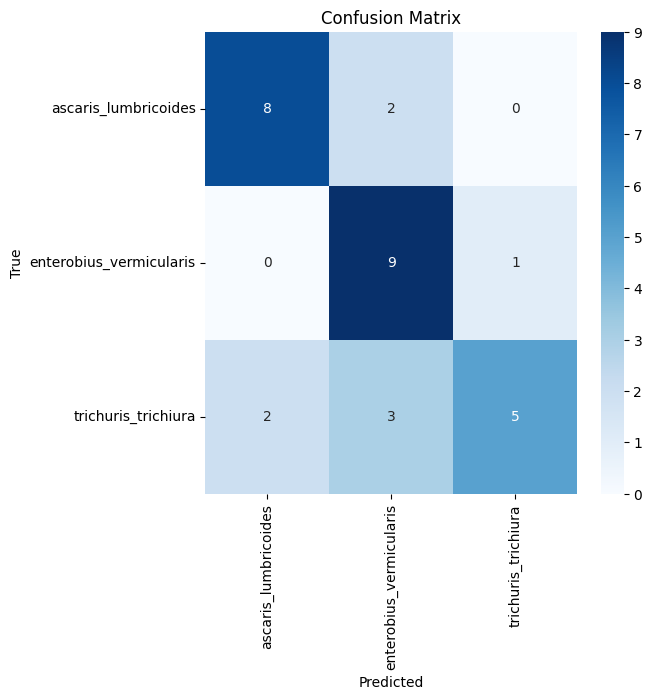

In [22]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Config
# ======================
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
TEST_DIR = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/validate"
MODEL_PATH = "/content/drive/MyDrive/Thesis/Saved AI models/sept82025_training/training1/efficientnet_parasite_final.keras"

# ======================
# Preprocessing (SAME as training)
# ======================
def grayscale_to_rgb(img):
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale [0,1]
    img = grayscale_to_rgb(img)                         # expand to RGB
    return img

def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

# ======================
# Load Data
# ======================
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen_processed = preprocess_generator(test_gen)

# ======================
# Load Model
# ======================
model = tf.keras.models.load_model(MODEL_PATH)

# ======================
# Predictions
# ======================
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen_processed, steps=test_gen.samples // BATCH_SIZE + 1)
y_pred = np.argmax(y_pred_probs, axis=1)

# ======================
# Evaluation
# ======================
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# 2nd Test Training

In [23]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 60
DATASET_DIR_TRAIN = "/content/drive/MyDrive/Thesis/parasite/train"
DATASET_DIR_VAL = "/content/drive/MyDrive/Thesis/parasite/val"

In [24]:
def grayscale_to_rgb(img):
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = grayscale_to_rgb(img)
    return img

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(
    DATASET_DIR_TRAIN,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    DATASET_DIR_VAL,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

train_gen_processed = preprocess_generator(train_gen)
val_gen_processed = preprocess_generator(val_gen)

Found 810 images belonging to 3 classes.
Found 90 images belonging to 3 classes.


In [30]:
# Base model
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
)

# Classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(
    train_gen.num_classes,
    activation="softmax",
    kernel_regularizer=l2(1e-4)
)(x)

model = Model(inputs=base_model.input, outputs=outputs)

# --- Phase 1: Train top layers ---
for layer in base_model.layers:
    layer.trainable = False  # freeze entire base model

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)
]

steps_per_epoch = len(train_gen)
val_steps = len(val_gen)

history = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 56s 686ms/step - accuracy: 0.3955 - loss: 1.1387 - val_accuracy: 0.6333 - val_loss: 0.8928 - learning_rate: 1.0000e-04
Epoch 2/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.5436 - loss: 0.9556 - val_accuracy: 0.7444 - val_loss: 0.7730 - learning_rate: 1.0000e-04
Epoch 3/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.6260 - loss: 0.8499 - val_accuracy: 0.7778 - val_loss: 0.6858 - learning_rate: 1.0000e-04
Epoch 4/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.7076 - loss: 0.7208 - val_accuracy: 0.7778 - val_loss: 0.6182 - learning_rate: 1.0000e-04
Epoch 5/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.7396 - loss: 0.6805 - val_accuracy: 0.7889 - val_loss: 0.5668 - learning_rate: 1.0000e-04
Epoch 6/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - accuracy: 0.8016 - loss: 0.5916 - val_accuracy: 0.8000 - val_loss: 0.5263 - learning_rate: 1.0000e-04
Epoch 7/60
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 165ms/step - accura

In [31]:
for layer in base_model.layers[-30:]:  # unfreeze last 30
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # smaller LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=10,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE,
    callbacks=[
        ModelCheckpoint("best_model_finetuned.keras", monitor="val_loss", save_best_only=True),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 730ms/step - accuracy: 0.9081 - loss: 0.3093 - val_accuracy: 0.9459 - val_loss: 0.1149
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.9410 - loss: 0.2525 - val_accuracy: 0.9459 - val_loss: 0.1150
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.9413 - loss: 0.2473 - val_accuracy: 0.9500 - val_loss: 0.1422
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - accuracy: 0.9193 - loss: 0.2575 - val_accuracy: 0.9500 - val_loss: 0.1484
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - accuracy: 0.9579 - loss: 0.1861 - val_accuracy: 0.9625 - val_loss: 0.1304
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.9595 - loss: 0.1899 - val_accuracy: 0.9865 - val_loss: 0.0889
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - accuracy: 0.9689 - loss: 0.1498 - val_accuracy: 1.0000 - val_loss: 0.0787
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.9520 - loss: 0.1837 - val_accurac

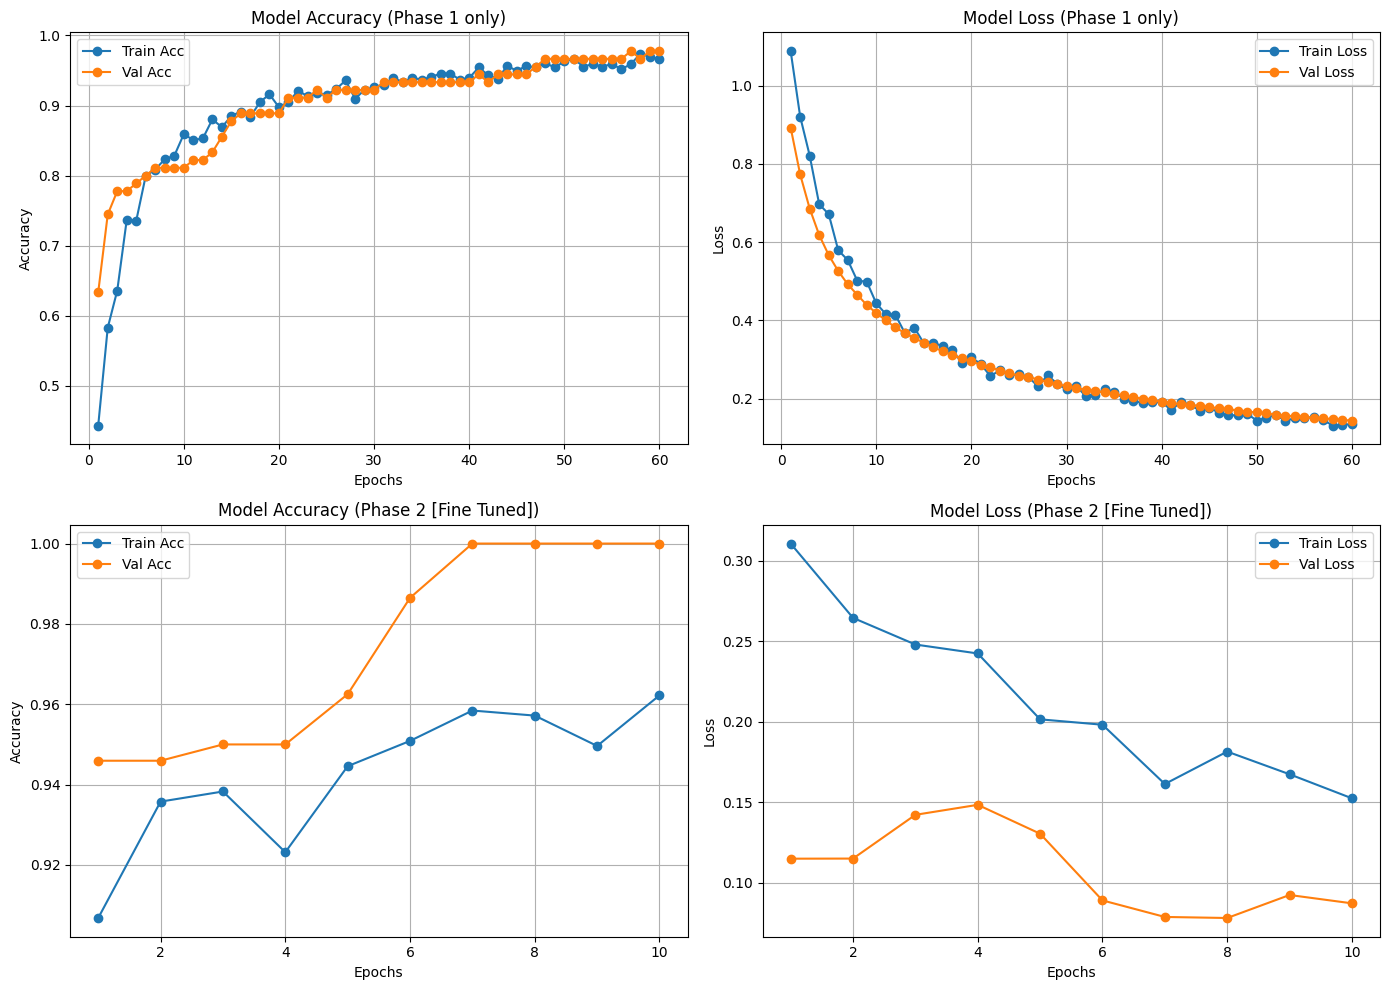

In [34]:
import matplotlib.pyplot as plt

# --- Phase 1 only ---
acc1 = history.history["accuracy"]
val_acc1 = history.history["val_accuracy"]
loss1 = history.history["loss"]
val_loss1 = history.history["val_loss"]

# --- Phase 2 only ---
acc2 = history_fine.history["accuracy"]
val_acc2 = history_fine.history["val_accuracy"]
loss2 = history_fine.history["loss"]
val_loss2 = history_fine.history["val_loss"]

epochs1 = range(1, len(acc1) + 1)
epochs2 = range(1, len(acc2) + 1)

plt.figure(figsize=(14,10))

# 1. Accuracy (Phase 1 only)
plt.subplot(2,2,1)
plt.plot(epochs1, acc1, label="Train Acc", marker="o")
plt.plot(epochs1, val_acc1, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 2. Loss (Phase 1 only)
plt.subplot(2,2,2)
plt.plot(epochs1, loss1, label="Train Loss", marker="o")
plt.plot(epochs1, val_loss1, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 3. Accuracy (Phase 2 only, fine-tuning)
plt.subplot(2,2,3)
plt.plot(epochs2, acc2, label="Train Acc", marker="o")
plt.plot(epochs2, val_acc2, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 4. Loss (Phase 2 only, fine-tuning)
plt.subplot(2,2,4)
plt.plot(epochs2, loss2, label="Train Loss", marker="o")
plt.plot(epochs2, val_loss2, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step

Classification Report:
                         precision    recall  f1-score   support

    ascaris_lumbriocode     1.0000    1.0000    1.0000        30
enterobius_vermicularis     1.0000    1.0000    1.0000        30
    trichuris_trichuria     1.0000    1.0000    1.0000        30

               accuracy                         1.0000        90
              macro avg     1.0000    1.0000    1.0000        90
           weighted avg     1.0000    1.0000    1.0000        90



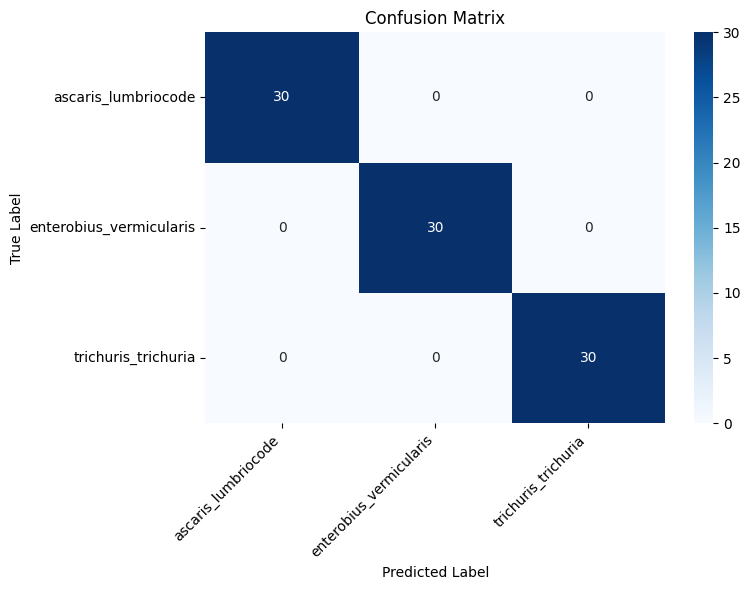

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Predictions ---
val_gen.reset()
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_labels,
    digits=4,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Found 30 images belonging to 3 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 8s/step

Classification Report:

                         precision    recall  f1-score   support

   ascaris_lumbricoides       0.75      0.90      0.82        10
enterobius_vermicularis       0.71      1.00      0.83        10
    trichuris_trichiura       1.00      0.40      0.57        10

               accuracy                           0.77        30
              macro avg       0.82      0.77      0.74        30
           weighted avg       0.82      0.77      0.74        30



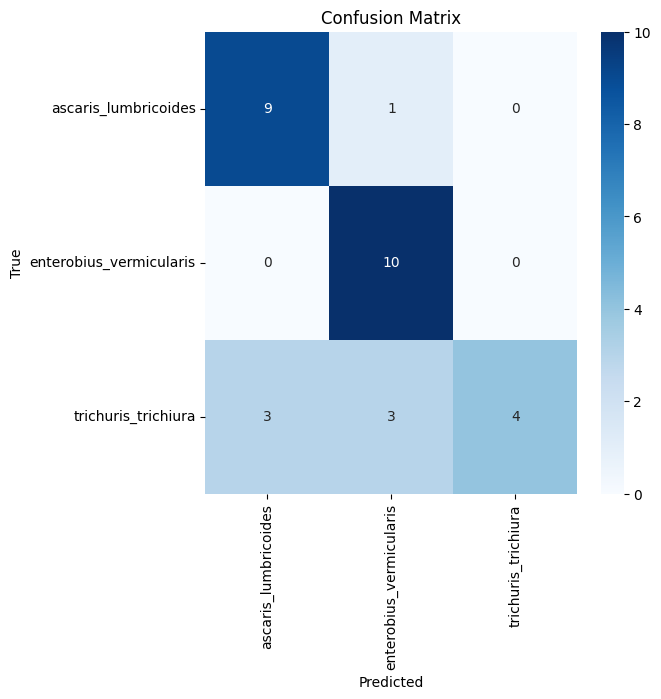

In [35]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ======================
# Config
# ======================
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
TEST_DIR = "/content/drive/MyDrive/Thesis/Jericho_Data_Set/validate"
MODEL_PATH = "/content/drive/MyDrive/Thesis/Saved AI models/sept82025_training/training2/best_model_finetuned.keras"

# ======================
# Preprocessing (SAME as training)
# ======================
def grayscale_to_rgb(img):
    return tf.image.grayscale_to_rgb(img)

def custom_preprocess(img):
    img = tf.image.convert_image_dtype(img, tf.float32)  # scale [0,1]
    img = grayscale_to_rgb(img)                         # expand to RGB
    return img

def preprocess_generator(generator):
    for batch_x, batch_y in generator:
        yield custom_preprocess(batch_x), batch_y

# ======================
# Load Data
# ======================
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen_processed = preprocess_generator(test_gen)

# ======================
# Load Model
# ======================
model = tf.keras.models.load_model(MODEL_PATH)

# ======================
# Predictions
# ======================
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen_processed, steps=test_gen.samples // BATCH_SIZE + 1)
y_pred = np.argmax(y_pred_probs, axis=1)

# ======================
# Evaluation
# ======================
class_labels = list(test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# test

In [ ]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# --- Focal Loss ---
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        ce = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow((1 - y_pred), gamma)
        return tf.reduce_sum(weight * ce, axis=1)
    return loss

# --- Base Model ---
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
)

# --- Classification Head ---
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
outputs = Dense(
    train_gen.num_classes,
    activation="softmax",
    kernel_regularizer=l2(1e-4)
)(x)

model = Model(inputs=base_model.input, outputs=outputs)

# --- Phase 1: Train head only ---
for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2., alpha=0.25),  # <---- focal loss
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)
]

steps_per_epoch = len(train_gen)
val_steps = len(val_gen)

history = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks
)

Epoch 1/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 661ms/step - accuracy: 0.2778 - loss: 0.2441 - val_accuracy: 0.2250 - val_loss: 0.2150 - learning_rate: 1.0000e-04
Epoch 2/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 224ms/step - accuracy: 0.3572 - loss: 0.2087 - val_accuracy: 0.3250 - val_loss: 0.2019 - learning_rate: 1.0000e-04
Epoch 3/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.4042 - loss: 0.1868 - val_accuracy: 0.3750 - val_loss: 0.1923 - learning_rate: 1.0000e-04
Epoch 4/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.3996 - loss: 0.1739 - val_accuracy: 0.3500 - val_loss: 0.1841 - learning_rate: 1.0000e-04
Epoch 5/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 226ms/step - accuracy: 0.5015 - loss: 0.1598 - val_accuracy: 0.3500 - val_loss: 0.1777 - learning_rate: 1.0000e-04
Epoch 6/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.5192 - loss: 0.1540 - val_accuracy: 0.4000 - val_loss: 0.1707 - learning_rate: 1.0000e-04
Epoch 7/60
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy:

In [ ]:
# --- Phase 2: Fine-tune last 30 layers ---
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=focal_loss(gamma=2., alpha=0.25),  # <---- focal loss again
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen_processed,
    validation_data=val_gen_processed,
    epochs=10,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_steps=val_gen.samples // BATCH_SIZE,
    callbacks=[
        ModelCheckpoint("best_model_finetuned.keras", monitor="val_loss", save_best_only=True),
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    ]
)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 44s 719ms/step - accuracy: 0.7262 - loss: 0.1049 - val_accuracy: 0.4167 - val_loss: 0.1685
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - accuracy: 0.7968 - loss: 0.0703 - val_accuracy: 0.4583 - val_loss: 0.1678
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7856 - loss: 0.0778 - val_accuracy: 0.4583 - val_loss: 0.1696
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.7506 - loss: 0.0757 - val_accuracy: 0.4167 - val_loss: 0.1743
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.7628 - loss: 0.0786 - val_accuracy: 0.4167 - val_loss: 0.1757
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 0.8271 - loss: 0.0632 - val_accuracy: 0.4167 - val_loss: 0.1770
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8205 - loss: 0.0690 - val_accuracy: 0.3750 - val_loss: 0.1777


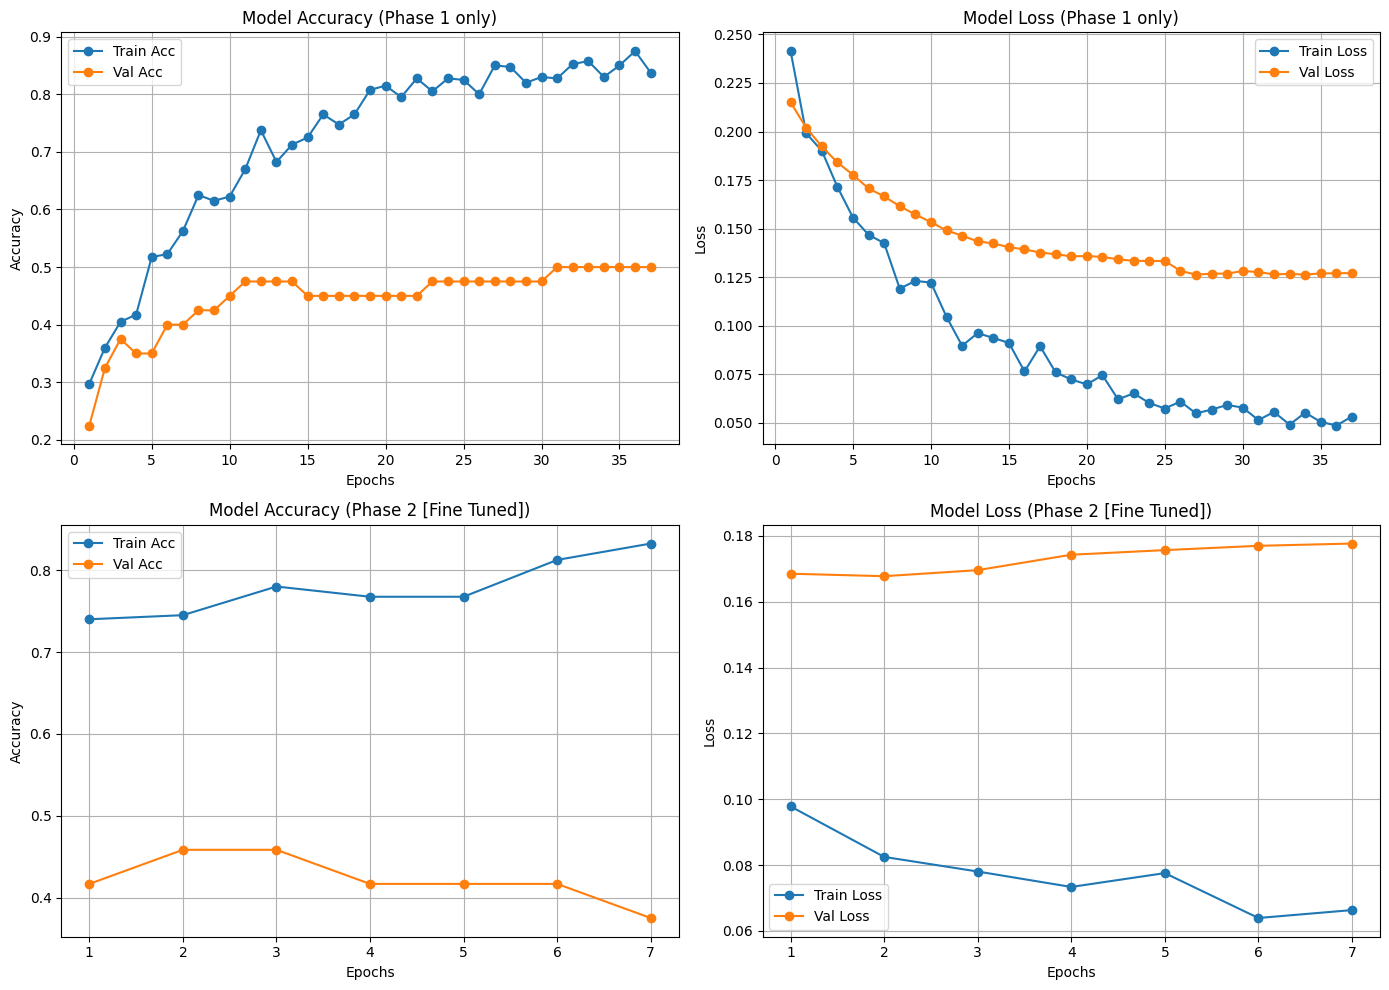

In [ ]:
import matplotlib.pyplot as plt

# --- Phase 1 only ---
acc1 = history.history["accuracy"]
val_acc1 = history.history["val_accuracy"]
loss1 = history.history["loss"]
val_loss1 = history.history["val_loss"]

# --- Phase 2 only ---
acc2 = history_fine.history["accuracy"]
val_acc2 = history_fine.history["val_accuracy"]
loss2 = history_fine.history["loss"]
val_loss2 = history_fine.history["val_loss"]

epochs1 = range(1, len(acc1) + 1)
epochs2 = range(1, len(acc2) + 1)

plt.figure(figsize=(14,10))

# 1. Accuracy (Phase 1 only)
plt.subplot(2,2,1)
plt.plot(epochs1, acc1, label="Train Acc", marker="o")
plt.plot(epochs1, val_acc1, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 2. Loss (Phase 1 only)
plt.subplot(2,2,2)
plt.plot(epochs1, loss1, label="Train Loss", marker="o")
plt.plot(epochs1, val_loss1, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 1 only)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# 3. Accuracy (Phase 2 only, fine-tuning)
plt.subplot(2,2,3)
plt.plot(epochs2, acc2, label="Train Acc", marker="o")
plt.plot(epochs2, val_acc2, label="Val Acc", marker="o")
plt.title("Model Accuracy (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# 4. Loss (Phase 2 only, fine-tuning)
plt.subplot(2,2,4)
plt.plot(epochs2, loss2, label="Train Loss", marker="o")
plt.plot(epochs2, val_loss2, label="Val Loss", marker="o")
plt.title("Model Loss (Phase 2 [Fine Tuned])")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step

Classification Report:
                         precision    recall  f1-score   support

   ascaris_lumbricoides     0.5833    0.7000    0.6364        10
enterobius_vermicularis     0.5263    1.0000    0.6897        10
              hookworms     1.0000    0.1000    0.1818        10
    trichuris_trichiura     0.7500    0.6000    0.6667        10

               accuracy                         0.6000        40
              macro avg     0.7149    0.6000    0.5436        40
           weighted avg     0.7149    0.6000    0.5436        40



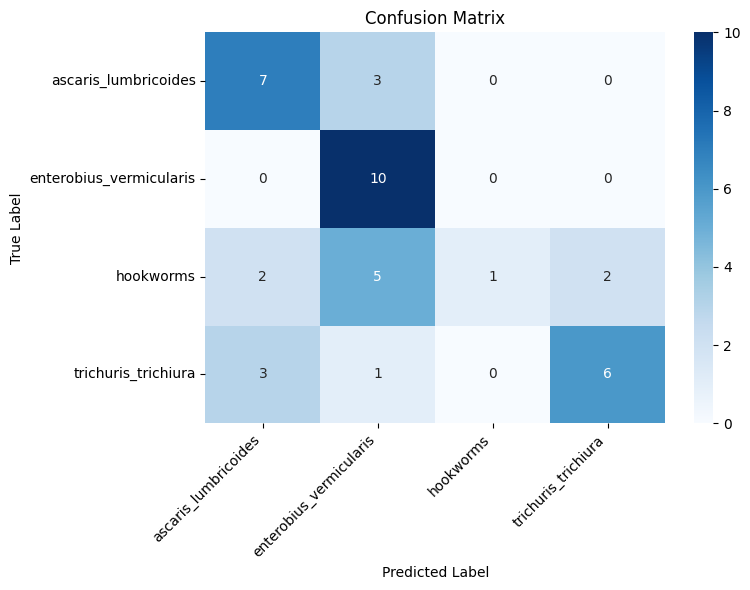

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Predictions ---
val_gen.reset()
y_pred_probs = model.predict(val_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_labels,
    digits=4,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()